In [1]:
import numpy as np
import pandas as pd
import cv2
from os import getcwd

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from keras.applications.vgg16 import VGG16

import utils
import time
import pickle

Using TensorFlow backend.


In [2]:
project_path = getcwd()
pickle_path = ".\\pickles\\"

In [3]:
df = pd.read_csv('styles.csv', error_bad_lines = False)
df.head()

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


### KMeans on equally sampled images from subcategories

In [4]:
MIN_COUNT = 900

In [5]:
# Getting list of categroies where their count is greater than 900
categories = list(df['subCategory'].value_counts()[df['subCategory'].value_counts() > MIN_COUNT].index)

In [6]:
df = df[df['subCategory'].isin(categories)]
df['subCategory'].value_counts()

Topwear       15402
Shoes          7343
Bags           3055
Bottomwear     2694
Watches        2542
Innerwear      1808
Jewellery      1079
Eyewear        1073
Fragrance      1011
Sandal          963
Wallets         933
Flip Flops      913
Name: subCategory, dtype: int64

In [7]:
# Sampling equal number of values from each category
df = df.groupby('subCategory').apply(lambda x: x.sample(n = MIN_COUNT, random_state = 99)).reset_index(drop = True)
df['subCategory'].value_counts()

Eyewear       900
Shoes         900
Fragrance     900
Sandal        900
Innerwear     900
Flip Flops    900
Topwear       900
Bags          900
Jewellery     900
Watches       900
Bottomwear    900
Wallets       900
Name: subCategory, dtype: int64

In [8]:
%time
images, image_idx, y = utils.read_images('images', df['id'], extension = 'jpg', 
                              shape = (80, 60, 3), labels = df['masterCategory'], verbose = 1)

Wall time: 0 ns
Extracted 1000 images out of 10800
Extracted 2000 images out of 10800
Extracted 3000 images out of 10800
Extracted 4000 images out of 10800
Extracted 5000 images out of 10800
Extracted 6000 images out of 10800
Extracted 7000 images out of 10800
Extracted 8000 images out of 10800
Extracted 9000 images out of 10800
Extracted 10000 images out of 10800


In [9]:
images.shape

(10796, 80, 60, 3)

In [17]:
'''
model = VGG16(weights = 'imagenet', input_shape = images[0].shape, include_top = False)
model.trainable = False
model.summary()
'''

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 60, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 60, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 60, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 30, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 30, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 30, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 15, 128)       0     

In [13]:
'''
# Getting embeddings from images
embedded_images = model.predict(images, verbose = 1)
embedded_images.shape
'''


10796/10796 [==============================] - 332s 31ms/step


(10796, 2, 1, 512)

In [14]:
'''
embedded_images_dict = {'data': embedded_images, 'model': model, 
                        'master_labels': df['masterCategory'][y], 
                        'sub_labels': df['subCategory'][y], 
                        'images': df['id'][y], 'indices': y}
'''

In [16]:
'''
# Saving embedded images into a pickle file
utils.save_pickle(file = pickle_path + "embedded_images_sub", variable = embedded_images_dict)
'''

Variable successfully saved in .\pickles\embedded_images.pickle


In [10]:
embedded_images_dict = utils.open_pickle(file = pickle_path + "embedded_images_sub")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



C:\Users\Smit\Miniconda3\envs\tensorflow\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [11]:
embedded_images = embedded_images_dict['data']

In [12]:
# Reshaping the embeddings into a shape that TSNE understands, (TSNE requires 2d matrix as input)
embedded_images = embedded_images.reshape(embedded_images.shape[0], 
                                          embedded_images.shape[1] * embedded_images.shape[2] * embedded_images.shape[3])
embedded_images.shape

(10796, 1024)

In [15]:
'''
# TSNE using embeddings created from VGG16
start_time = time.time()

tsne = TSNE(n_components = 2)
tsne_results = tsne.fit_transform(embedded_images)

run_time = time.time() - start_time
print('Run time: ' + str(int(run_time/60)) + 'm' + str(int(run_time%60)) + 's')
'''

Run time: 5m51s


In [18]:
'''
tsne_results_dict = {'data': tsne_results, 'embedded_images': True,
                     'embedding_model': model, 
                     'tsne_model': tsne,
                     'master_labels': df['masterCategory'][y], 
                     'sub_labels': df['subCategory'][y], 
                     'images': df['id'][y]}
'''

In [19]:
'''
# Saving TSNE results into pickle file
utils.save_pickle(file = 'tsne_results_on_embeddings_sub', variable = tsne_results_dict)
'''

Variable successfully saved in tsne_results_on_embeddings_sub.pickle


In [13]:
tsne_results_dict = utils.open_pickle(file = 'tsne_results_on_embeddings_sub')

In [14]:
tsne_results = tsne_results_dict['data']
tsne = tsne_results_dict['tsne_model']
master_category = tsne_results_dict['master_labels']
sub_category = tsne_results_dict['sub_labels']

In [15]:
# Creating a dataframe for plotting results
df_transformed = pd.DataFrame({'comp1': tsne_results[:,0], 'comp2': tsne_results[:,1], 'category': master_category,
                              'subcategory': sub_category})

df_transformed.head()

,comp1,comp2,category,subcategory
0,-18.278055,-11.348943,Accessories,Bags
1,-11.246380,-40.754978,Accessories,Bags
2,0.133814,6.442611,Accessories,Bags
3,-50.497921,-33.268436,Accessories,Bags
4,-43.992393,-43.951729,Accessories,Bags


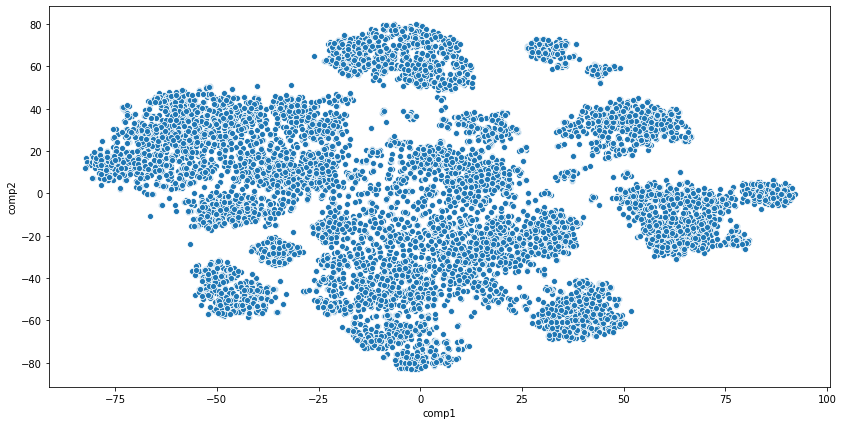

In [16]:
plt.subplots(figsize = (14, 7))
sns.scatterplot(x = 'comp1', y = 'comp2', data = df_transformed)

In [17]:
kmeans = KMeans(n_clusters = 12, n_init = 10, random_state = 99, verbose = 1, n_jobs = -1)
kmeans = kmeans.fit(embedded_images)

In [18]:
df_transformed['kmeans'] = kmeans.labels_

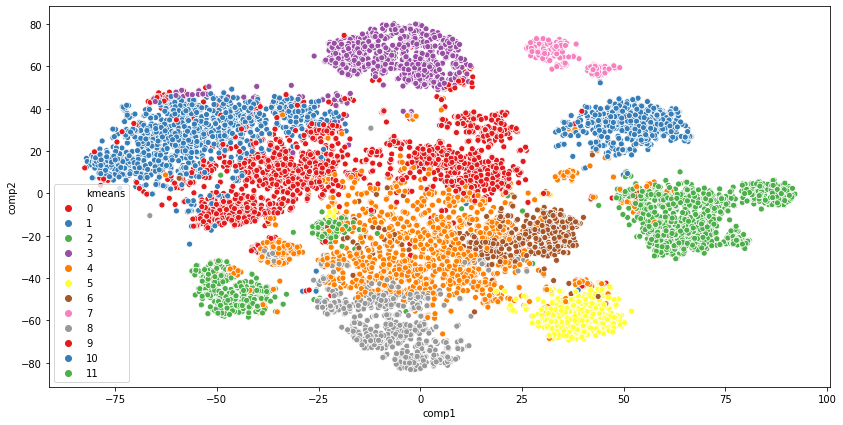

In [19]:
# Plotting clusters formed by kmeans
plt.subplots(figsize = (14, 7))
sns.scatterplot(x = 'comp1', y = 'comp2', hue = 'kmeans', data = df_transformed, 
                legend = 'full', palette = sns.color_palette("Set1", n_colors=12))

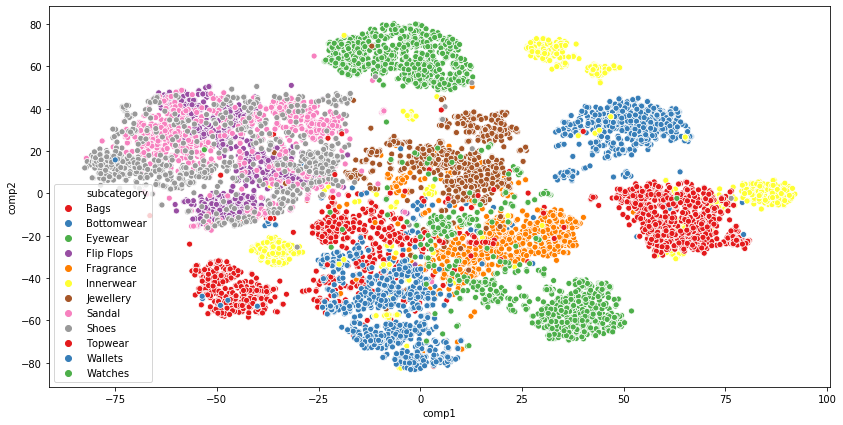

In [20]:
# Plotting actual clusters
plt.subplots(figsize = (14, 7))
sns.scatterplot(x = 'comp1', y = 'comp2', hue = 'subcategory', data = df_transformed, 
                legend = 'full', palette = sns.color_palette("Set1", n_colors=12))

In [23]:
# Saving K-Means model in pickle file
utils.save_pickle(file = pickle_path + 'KMeans_embeddings_clusters_sub_12', variable = kmeans)

Variable successfully saved in .\pickles\KMeans_embeddings_clusters_sub_12.pickle


### KMeans on all images

In [24]:
# Reading embeddings for all images in dataset
embedded_images_all_dict = utils.open_pickle(file = pickle_path + 'embedded_images_all.pickle')

C:\Users\Smit\Miniconda3\envs\tensorflow\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [25]:
# Getting actual embeddings and labels associated with them
embedded_images_all = embedded_images_all_dict['data']
sub_labels_all = embedded_images_all_dict['sub_labels']
master_labels_all = embedded_images_all_dict['master_labels']

In [26]:
sub_labels_all.value_counts()

Topwear                     15395
Shoes                        7342
Bags                         3051
Bottomwear                   2692
Watches                      2541
Innerwear                    1807
Jewellery                    1078
Eyewear                      1073
Fragrance                    1010
Sandal                        963
Wallets                       933
Flip Flops                    913
Belts                         811
Socks                         698
Lips                          526
Dress                         478
Loungewear and Nightwear      470
Saree                         424
Nails                         329
Makeup                        306
Headwear                      293
Ties                          256
Accessories                   129
Scarves                       116
Cufflinks                     108
Apparel Set                   106
Stoles                         90
Skin Care                      77
Skin                           68
Eyes          

In [27]:
master_labels_all.value_counts()

Apparel          21384
Accessories      11264
Footwear          9218
Personal Care     2399
Name: masterCategory, dtype: int64

In [28]:
# Reading TSNE results for all images
tsne_results_all_dict = utils.open_pickle(file = pickle_path + 'tsne_results_on_embeddings_all')

In [29]:
tsne_results_all_dict.keys()

dict_keys(['data', 'embedded_images', 'model', 'master_labels', 'sub_labels', 'images'])

In [30]:
# Getting actual TSNE results and verifying if sub labels from embedded images dictionary 
# are the same as sub labels from tsne results dictionary
tsne_results_all = tsne_results_all_dict['data']
print("Number of non matches for sub labels: ", (sub_labels_all != tsne_results_all_dict['sub_labels']).sum())  
print("Number of non matches for master labels: ", (master_labels_all != tsne_results_all_dict['master_labels']).sum())

Number of non matches for sub labels:  0
Number of non matches for master labels:  0


In [31]:
# Creating a dataframe for plotting results
df_transformed_all = pd.DataFrame({'comp1': tsne_results_all[:,0], 'comp2': tsne_results_all[:,1], 
                                   'category': master_labels_all, 'subcategory': sub_labels_all})

df_transformed_all.head()

,comp1,comp2,category,subcategory
0,-18.102343,48.253979,Apparel,Topwear
1,-39.493855,-43.023140,Apparel,Bottomwear
2,47.336544,-18.864847,Accessories,Watches
3,-35.978355,-39.636360,Apparel,Bottomwear
4,-43.682297,26.836388,Apparel,Topwear


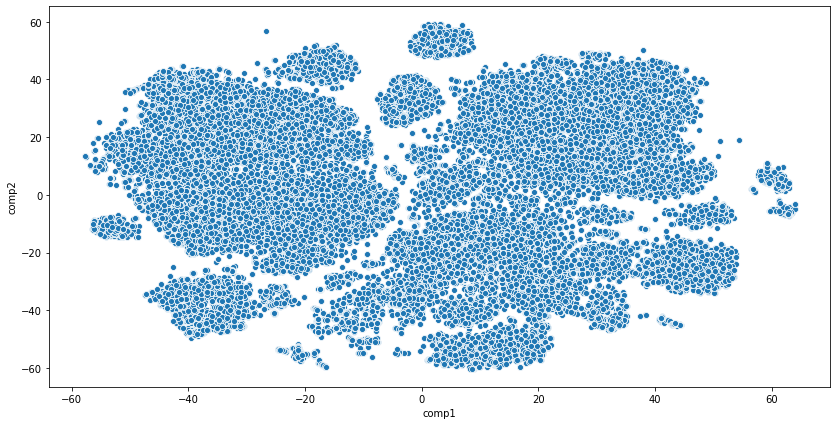

In [32]:
plt.subplots(figsize = (14, 7))
sns.scatterplot(x = 'comp1', y = 'comp2', data = df_transformed_all)

In [33]:
# Reshaping the embeddings into a shape that KMeans understands, (KMeans requires 2d matrix as input)
embedded_images_all = embedded_images_all.reshape(
    embedded_images_all.shape[0], 
    embedded_images_all.shape[1] * embedded_images_all.shape[2] * embedded_images_all.shape[3])
embedded_images_all.shape

(44265, 1024)

In [34]:
kmeans_all = KMeans(n_clusters = 12, n_init = 10, random_state = 99, verbose = 1, n_jobs = -1)
kmeans_all.fit(embedded_images_all)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=99, tol=0.0001, verbose=1)

In [35]:
df_transformed_all['kmeans'] = kmeans_all.labels_

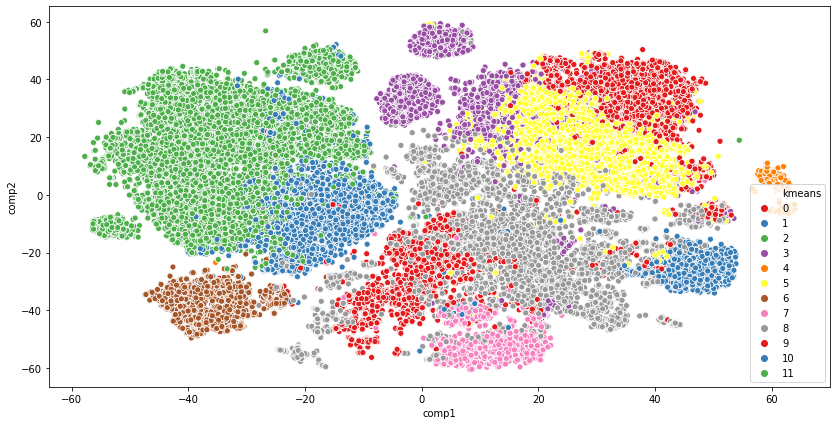

In [36]:
# Plotting clusters formed by kmeans
plt.subplots(figsize = (14, 7))
sns.scatterplot(x = 'comp1', y = 'comp2', hue = 'kmeans', data = df_transformed_all, 
                legend = 'full', palette = sns.color_palette("Set1", n_colors=12))

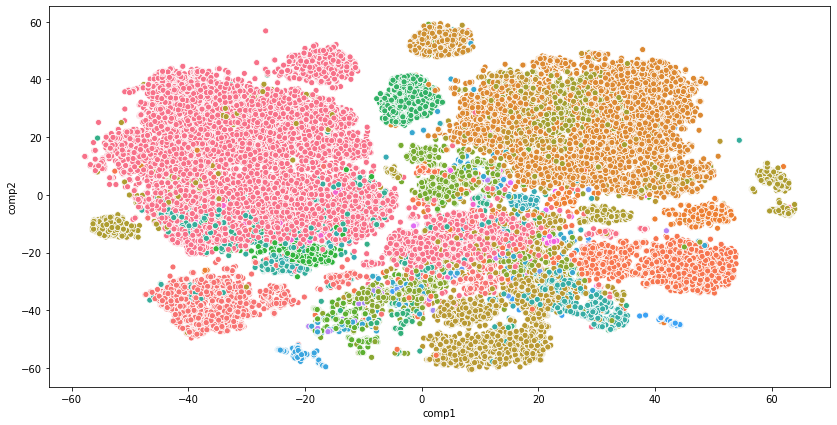

In [37]:
# Plotting actual clusters
plt.subplots(figsize = (14, 7))
sns.scatterplot(x = 'comp1', y = 'comp2', hue = 'subcategory', data = df_transformed_all, legend = False)

In [38]:
# Saving K-Means model in pickle file
utils.save_pickle(file = pickle_path + 'KMeans_embeddings_clusters_all_12', variable = kmeans_all)

Variable successfully saved in .\pickles\KMeans_embeddings_clusters_all_12.pickle
